In [1]:
import csv
import torch as tr
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
import unidecode
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dragfire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/dragfire/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
with open('data/labeled_data.csv') as data:
    csv_data = [row for row in csv.DictReader(data)]

In [3]:
MAX_TOKEN_LEN = 12
MIN_TOKEN_LEN = 3

def preprocess_text(text):
    # Remove accents from text
    text = unidecode.unidecode(text)

    # Convert text to lowercase
    text = text.lower()

    # Handle contractions
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # Remove @user, nums, URLs and emails
    text = re.sub(r"@\S+|http\S+|www\S+|https\S+|\S+@\S+|\S*\d+\S*", "", text)


    # Handle emojis
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         "]+",
        flags=re.UNICODE,
    )
    text = emoji_pattern.sub(r"", text)

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    return text

def tokenize_text(text):
    # Get the English stopwords
    stop_words = set(stopwords.words('english'))

    # Tokenize the text
    tokenizer = get_tokenizer('basic_english')
    tokens = tokenizer(text)

    tokens = [token for token in tokens if token not in stop_words and not None and len(token) <= MAX_TOKEN_LEN and len(token) >= MIN_TOKEN_LEN]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    tokens.append('<unk>')

    return tokens

def build_vocab(tokens):
    return set(tokens)

In [4]:
import random

# Define the ratio for train, test, and validation sets
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15
batch_size = 64

def padded_batch(batch):
    max_length = max(len(seq) for seq in batch)
    padded_batch = [torch.cat([seq, torch.zeros(max_length - len(seq), dtype=tr.int)]) for seq in batch]
    return torch.stack(padded_batch)

def build_dataset():
    num_samples = len(csv_data)
    num_train_samples = int(train_ratio * num_samples)
    num_test_samples = int(test_ratio * num_samples)

    indices = list(range(num_samples))
    random.shuffle(indices)

    train_data = [csv_data[i] for i in indices[:num_train_samples]]
    test_data = [csv_data[i] for i in indices[num_train_samples:num_train_samples + num_test_samples]]
    val_data = [csv_data[i] for i in indices[num_train_samples + num_test_samples:]]
    
    return train_data, test_data, val_data

train_data, test_data, val_data = build_dataset()

def create_batches(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

print("Train data size:", len(train_data))
print("Test data size:", len(test_data))
print("Validation data size:", len(val_data))


Train data size: 17348
Test data size: 3717
Validation data size: 3718


In [5]:
device = tr.device('mps') if tr.backends.mps.is_available() else tr.device('cpu')
device

device(type='mps')

In [6]:
text = ''.join([row['tweet'] for row in train_data])
text = preprocess_text(text)
tokens = tokenize_text(text)
vocab = build_vocab(tokens)
tokens_len = [len(token) for token in tokens]
word_to_ix = {word: i for i, word in enumerate(vocab)}

len(tokens), len(vocab), max(tokens_len), min(tokens_len)

(117053, 16933, 12, 1)

In [7]:
def line_to_indices(line):
    tokens = tokenize_text(preprocess_text(line))
    # print("Tokens:", tokens)
    return tr.tensor([word_to_ix.get(w, word_to_ix['<unk>']) for w in tokens])

def input_output(batch):
    xb = [line_to_indices(row['tweet']) for row in batch]
    xb = padded_batch(xb)
    xb = xb.view(xb.shape[0], 1, xb.shape[1])
    yb = tr.tensor([int(row['class']) for row in batch])
    return xb, yb

train_batches = [input_output(b) for b in create_batches(train_data, batch_size)]
test_batches = [input_output(b) for b in create_batches(test_data, batch_size)]
val_batches = [input_output(b) for b in create_batches(val_data, batch_size)]
print("Train batch count:", len(train_batches))
print("Test batch count:", len(test_batches))
print("Validation batch count:", len(val_batches))

Train batch count: 272
Test batch count: 59
Validation batch count: 59


In [8]:
len(csv_data), csv_data[:2]

(24783,
 [{'': '0',
   'count': '3',
   'hate_speech': '0',
   'offensive_language': '0',
   'neither': '3',
   'class': '2',
   'tweet': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."},
  {'': '1',
   'count': '3',
   'hate_speech': '0',
   'offensive_language': '3',
   'neither': '0',
   'class': '1',
   'tweet': '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!'}])

In [9]:
train_batches[0][0].shape, train_batches[0][1].shape

(torch.Size([64, 1, 15]), torch.Size([64]))

In [10]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 25
CLASSES = 3

VOCAB_SIZE

16933

In [11]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size=64, CLASSES=3, dropout_prob=0.5):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_size, 2, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(3 * hidden_size)
        self.fc1 = nn.Linear(hidden_size, 3 * hidden_size)
        self.fc3 = nn.Linear(3 * hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, CLASSES)
    
    def forward(self, x):
        out = self.emb(x)
        out, _ = self.rnn(out.view(out.shape[0], out.shape[2], out.shape[3]))
        out = self.layer_norm1(out)
        out = self.dropout(out)
        out = F.relu(self.fc1(out))
        out = self.layer_norm2(out)
        out = self.dropout(out)
        out = F.relu(self.fc3(out))
        out = self.layer_norm1(out)
        out = self.dropout(out)
        out = self.fc4(out)
        out = out.sum(dim=1)
        return out

model = Model(VOCAB_SIZE, EMBEDDING_DIM, hidden_size=64, dropout_prob=0.3)
model = model.to(device)

In [12]:
x = "hello world! ok then whatever fuck How are you?"

embed = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM, device=device)
x = line_to_indices(x).reshape(1, 1, -1)
x = x.to(device)
embed(x).size(), model(x).size()


(torch.Size([1, 1, 5, 25]), torch.Size([1, 3]))

In [24]:
EPOCHS = 25
LR = 1e-3
optimizer = tr.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

100%|██████████| 25/25 [01:29<00:00,  3.58s/it]


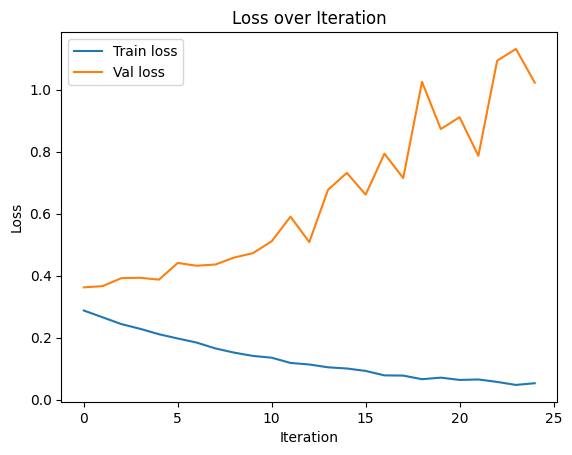

In [25]:
losses = []
val_losses = []

for k in tqdm(range(EPOCHS)):
    model.train()
    train_loss = 0.0
    for xb, yb in train_batches:
        xb = xb.to(device)
        yb = yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    with tr.no_grad():
        val_loss = 0.0
        for xb, yb in val_batches:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_batches))

    losses.append(train_loss / len(train_batches))

plt.plot(losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iteration')
plt.legend()
plt.show()

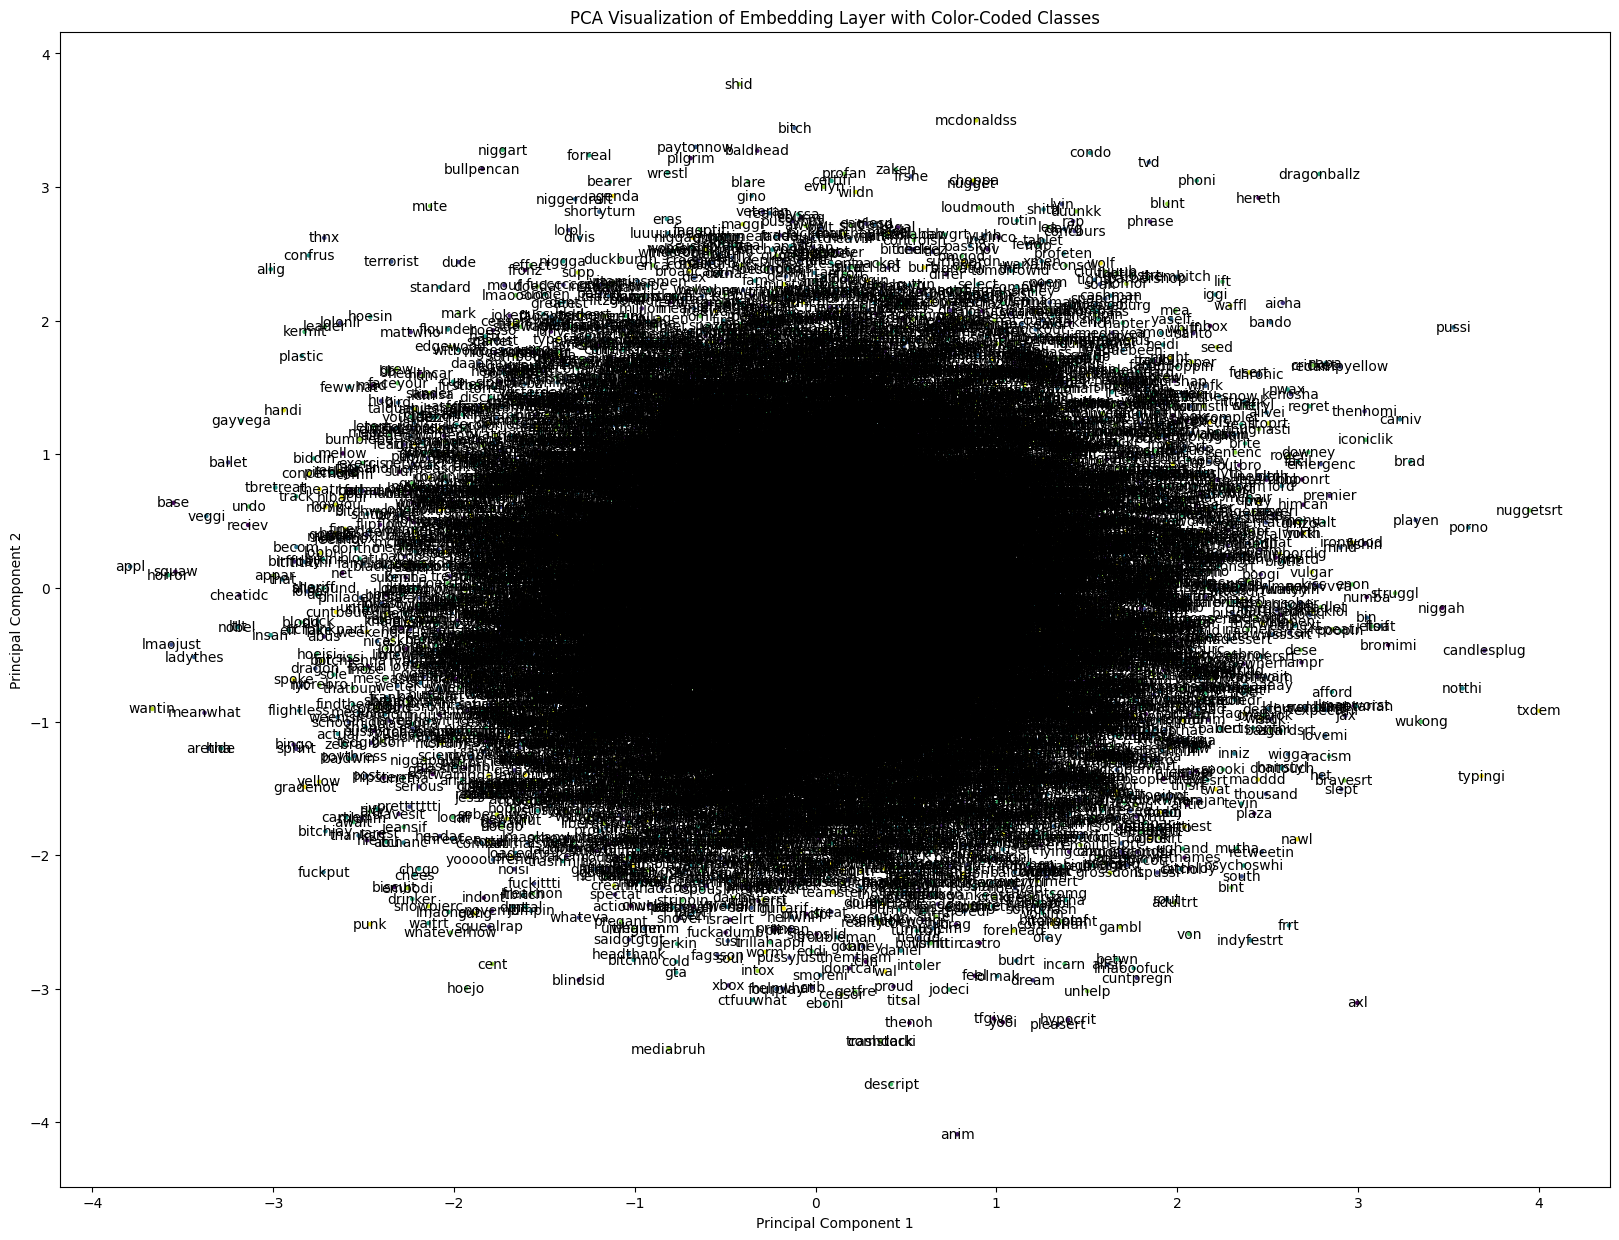

In [56]:
import numpy as np

embedding_weights = model.emb.weight.data.cpu()

# Assuming you have class labels for each embedding in 'class_labels' list
class_labels = [i for i in range(VOCAB_SIZE)] # Replace with your actual class labels
class_names = list(vocab)

# Convert the embedding weights to a NumPy array
embedding_weights_np = embedding_weights.numpy()

# Calculate the mean of the embeddings
mean_embedding = torch.mean(embedding_weights, dim=0)

# Center the embeddings
centered_embeddings = embedding_weights - mean_embedding

# Compute the covariance matrix
cov_matrix = torch.mm(centered_embeddings.t(), centered_embeddings)

# Perform Singular Value Decomposition (SVD) on the covariance matrix
U, S, V = torch.svd(cov_matrix)

# Select the top two principal components
pca_components = U[:, :2]

# Project the embeddings onto the first two principal components
embedded_points = torch.mm(centered_embeddings, pca_components)

# Convert the embeddings and class labels to NumPy arrays
embedded_points_np = embedded_points.numpy()
class_labels_np = np.array(class_labels)

# Plot the embeddings with color-coded classes
plt.figure(figsize=(20, 15))
plt.scatter(embedded_points_np[:, 0], embedded_points_np[:, 1], c=class_labels_np, cmap='viridis', s=5)
for i, label in enumerate(class_labels):
    plt.text(embedded_points_np[i, 0], embedded_points_np[i, 1], class_names[label], fontsize=10, ha='center', va='center')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Embedding Layer with Color-Coded Classes")
plt.show()

In [46]:
from torchmetrics import ConfusionMatrix
import itertools

model.eval()
class_labels = ['hate speech', 'offensive language', 'neutral']

def predict(line):
    x = line_to_indices(line).reshape(1, 1, -1)
    x = x.to(device)
    return class_labels[model(x).topk(1)[1].item()]

def plot_cf_matrix(batches):
  model.eval()
  confusion_matrix = ConfusionMatrix(task='multiclass', num_classes=CLASSES)

  with tr.no_grad():
    for xb, yb in batches:
        xb = xb.to(device)
        preds = tr.tensor(model(xb).topk(1).indices.reshape(1, -1).cpu().numpy()[0])

        confusion_matrix.update((preds), yb)

  result = confusion_matrix.compute()
  cm = result.numpy()

  ticks = np.arange(0, CLASSES)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.colorbar()
  plt.xticks(ticks, class_labels)
  plt.yticks(ticks, class_labels)

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, str(cm[i,j]))

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

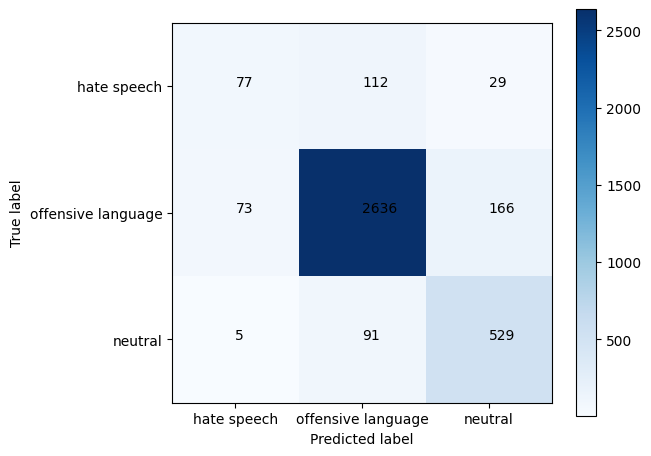

In [47]:
plot_cf_matrix(val_batches)

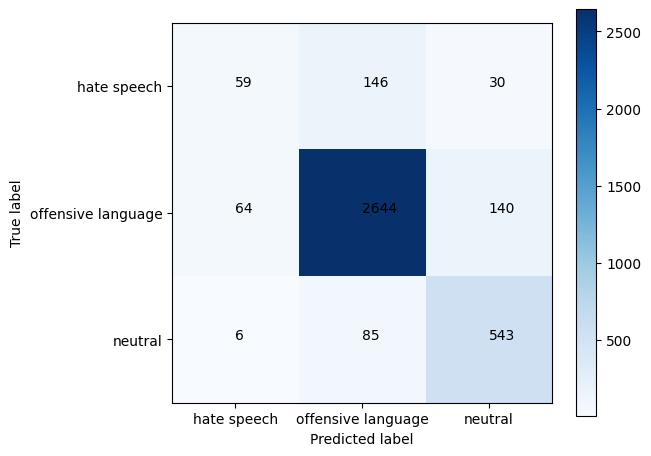

In [48]:
plot_cf_matrix(test_batches)

In [49]:
predict('Damn dawg you dumb af!')

'offensive language'

In [55]:
predict('All dolphins can go to hell!')

'hate speech'

In [51]:
predict('I am your master peasant')

'hate speech'

In [52]:
predict("something in the air")

'neutral'

In [53]:
tr.save(model, 'hate.speech.rnn.pth')